AICD provides membership lounges across the capitals in Australia. Members of AICD can visit these for meetings or for work. In the below presentation we'll analyze how members from different cities and industries visit AICD lounges. We'll also look for patterns based on members occupation and check if their companies office location and its distance to the local lounge has any influence on their behavior. 

This notebook is divided into 5 parts:

<a id='index'></a>
1. [Inital analysis](#eda1)
2. [Members visits by headquarters location](#byhq)
3. [Lounge visitors by industry and headquarters location](#byloc)
4. [Roles of AICD visitors](#roles)
5. [Spatial Analysis](#geo)

<a id='eda1'></a>
# 1. Inital analysis

In [1]:
import numpy as np 
import pandas as pd 
import geopy.distance
import matplotlib.pyplot as plt
# import plotly
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected=True)

df = pd.read_csv('members.csv')

# remove nulls and change negative avg_time to 'abs' int
df = df[~df['avg_dwell_time_in_min'].isnull()]
df['avg_dwell_time_in_min'] = abs(df['avg_dwell_time_in_min'])

# create a column with combined coordinates, and total_visits column: 
df['cords'] = tuple(zip(df['longitude'], df['latitude']))
df['total_visits'] = df['visits_sydney'] + df['visits_melbourne'] + df['visits_perth']

# remove total_visits nulls:
df = df[~(df['total_visits'] == 0) & ~(df['avg_dwell_time_in_min'] == 0)]

In [2]:
fig = px.histogram(df, x="total_visits",  color_discrete_sequence=['indigo'],title='Plot 1: Number of visits distribution')
fig.update_layout(xaxis_title_text='Number of visits')
fig.show()
fig = px.histogram(df, x="avg_dwell_time_in_min", color_discrete_sequence=['indianred'],title='Plot 2: Visits length distribution')
fig.update_layout(xaxis_title_text='Length of visits')
fig.show()

In [3]:
role_colors = ['#AB63FA', '#FFA15A', '#19D3F3','#FF6692']

fig = make_subplots(1, 2, specs=[[{'type':'domain'},{'type':'domain'}]],
                    subplot_titles=['Members job roles', 'Members HQ locations'])

fig.add_trace(go.Pie( values=df.groupby('role')['role'].count(), 
                     labels=['CEO','Chair','Exec Director','Non-Exec Director'] ,textinfo='label+percent', legendgroup = '1'), 1, 1)
fig.update_traces(marker=dict(colors=role_colors))

fig.add_trace(go.Pie(labels=df.groupby('headquarter_location')['role'].count().index, values=df.groupby('headquarter_location')['role'].count(),
                    textinfo='label+percent', legendgroup = '2'), 1, 2)
fig.update_layout(title_text='Plot 3: Member numbers by role and their headquarters location',legend_tracegroupgap = 80)
fig.show()

* large group of AICD members visited the lounges less than 20 times
    * plot 1 is right skewed with a very high concentration at its beginning on the left side
* the most popular meeting time is around 2 hours 
* The most common job title among AICD members is a CEO followed by Non-Executive Director 
* Sydney-based members dominate AICD lounges, followed by Melbourne and Perth.

In [4]:
# AICD lounge locations:
coords_syd = (-33.86336382479448, 151.20641568508086)
coords_melb = (-37.81651586387018, 144.96262374491673)
coords_perth = (-31.955428859202144, 115.85814550988445)

# divide the dataset based on hq location:
hq_syd = df[df['headquarter_location'] == 'Sydney'].copy()
hq_melb = df[df['headquarter_location'] == 'Melbourne'].copy()
hq_perth = df[df['headquarter_location'] == 'Perth'].copy()

# calculate distances members hq to aicd lounge:
hq_syd['sydney_distance'] = hq_syd['cords'].apply(lambda x: geopy.distance.distance(x, coords_syd).km)
hq_melb['melb_distance'] = hq_melb['cords'].apply(lambda x: geopy.distance.distance(x, coords_melb).km)
hq_perth['perth_distance'] = hq_perth['cords'].apply(lambda x: geopy.distance.distance(x, coords_perth).km)

<a id='byhq'></a>
# 2. Members visits by headquarters location
[back to top](#index)

In [5]:
fig = go.Figure(data=[
    go.Bar(name='Visits made to city', x=['Sydney','Melbourne','Perth'], y=df[['visits_sydney','visits_melbourne','visits_perth']].sum()),
    go.Bar(name='Visits made from city', x=['Melbourne','Perth','Sydney'], y=df.groupby('headquarter_location')['total_visits'].sum()),
])

fig.update_layout(
    title='Plot 4: Number of visits to and from each city',
    yaxis=dict(title='Number of all visits'),
    xaxis=dict(title='City')
)
fig.show()

In [6]:
# create a temp df for plotly:
plot5 = df.groupby('headquarter_location')[['visits_sydney','visits_melbourne','visits_perth']].sum().sort_values('visits_sydney',ascending=False)

labels_x = ['HQ in Sydney', 'HQ in Melbourne', 'HQ in Perth']
fig = go.Figure(data=[
    go.Bar(name='to Sydney', x=labels_x, y=plot5['visits_sydney']),
    go.Bar(name='to Melbourne', x=labels_x, y=plot5['visits_melbourne']),
    go.Bar(name='to Perth', x=labels_x, y=plot5['visits_perth']),
])

fig.update_layout(
    title='Plot 5: Visits by members headquarters location and destination',
    yaxis=dict(title='Number of visits'),
    xaxis=dict(title='HQ City'),
    barmode='group'
)
fig.show()

In [7]:
hq_labels=['to Sydney','to Melbourne','to Perth']

fig = make_subplots(1, 3, specs=[[{'type':'domain'},{'type':'domain'}, {'type':'domain'}]],
                    subplot_titles=['HQ in Sydney', 'HQ in Melbourne','HQ in Perth'])
fig.add_trace(go.Pie(labels=hq_labels, values=hq_syd[['visits_sydney','visits_melbourne','visits_perth']].sum(), scalegroup='one',
                     textinfo='label+percent',name="HQ in Sydney"), 1, 1)
fig.add_trace(go.Pie(labels=hq_labels, values=hq_melb[['visits_sydney','visits_melbourne','visits_perth']].sum(), scalegroup='one',
                     textinfo='label+percent',name="HQ in Melbourne"), 1, 2)
fig.add_trace(go.Pie(labels=hq_labels, values=hq_perth[['visits_sydney','visits_melbourne','visits_perth']].sum(), scalegroup='one',
                     textinfo='label+percent',name="HQ in Perth"), 1, 3)

fig.update_layout(title_text='Plot 6: Share of visits')
fig.show()

## Table 1: Members average visit numbers by their origin and destination 

In [8]:
df.groupby('headquarter_location')[['visits_sydney', 'visits_melbourne', 'visits_perth','total_visits']].mean().sort_values('visits_melbourne')

,visits_sydney,visits_melbourne,visits_perth,total_visits
headquarter_location,,,,
Sydney,15.302743,6.138186,6.137658,27.578586
Melbourne,11.669867,8.658789,11.765879,32.094535
Perth,11.446809,11.399420,13.320116,36.166344


* **Sydney-based members are the most loyal to their city** - they have the highest average number of visits in their headquarters city ~15 visits - (55.5% of their visits is within Sydney)
    * they're also the least likely to leave their city
* Perth-based members are most likely to visit Perth, those visits are not as dominant as in Sydney's case. Only 36.8% of their visits (on average 13.3 visits) are in Perth, followed closely by Sydney and Melbourne
* **Melbourne is the only city, which members don't favor their lounge**, Only 27% of Melbourne-based members visit Melbourne lounge (average of 8.7 visits). Both Perth and Sydney lounges are preferable for Melbourne-based members.




<a id='byloc'></a>
# 3. Lounge visitors by industry and hq
[back to top](#index)
### Table 2: Total visits by industry

In [9]:
cm = sns.light_palette("blue", as_cmap=True)
df.groupby('industry')[['visits_sydney','visits_melbourne','visits_perth','total_visits']].sum().sort_values('total_visits',ascending=False).style.background_gradient(cmap=cm, axis=0)

,visits_sydney,visits_melbourne,visits_perth,total_visits
industry,,,,
Financials,8687,5373,6311,20371
Health Care,8085,4942,6494,19521
Telecommunication,8133,5672,5565,19370
Media & Entertainment,8163,4895,6221,19279
Insurance,8048,5062,5333,18443
Energy,7727,4832,5750,18309
Software & Services,7808,4373,5667,17848


# Members from Sydney

In [10]:
colors = ['#646ffb', '#ef553b','#09cb96' ]
# who's leaving sydney?
plot7 = df[df['headquarter_location'] == 'Sydney'].groupby('industry')[['visits_melbourne','visits_perth']].sum().sort_values('visits_melbourne',ascending=False)

labels_x = ['to Perth','to Melbourne',]
fig = go.Figure(data=[
    go.Bar(name='to Melbourne', x=plot7['visits_melbourne'].index, y=plot7['visits_melbourne'],marker_color=colors[1]),
    go.Bar(name='to Perth', x=plot7['visits_perth'].index, y=plot7['visits_perth'],marker_color=colors[2])

])

fig.update_layout(
    title='Plot 7: Who is visiting from Sydney?',
    yaxis=dict(title='Number of visits', range=[0, 2500]),
    xaxis=dict(title='Industry'),
    barmode='group'
)
fig.show()

### Table 3: Sydney members visits

In [11]:
def df_style(val):
    return "font-weight: bold"
syd_out = hq_syd.groupby('industry')[['visits_sydney','visits_melbourne','visits_perth']].sum().sort_values('visits_melbourne',ascending=False).rename(columns={"visits_sydney":"Visits to Sydney","visits_melbourne": "Visits to Melbourne", "visits_perth": "Visits to Perth"})
syd_out.loc['TOTAL'] = syd_out[['Visits to Sydney','Visits to Melbourne','Visits to Perth']].sum()
syd_out.style.background_gradient(cmap=cm, subset=(syd_out.index[:-1],slice(None)), axis=0).applymap(df_style, subset=(syd_out.index[-1],slice(None)))

,Visits to Sydney,Visits to Melbourne,Visits to Perth
industry,,,
Financials,4251,1942,1859
Health Care,4464,1780,1781
Media & Entertainment,4185,1769,1774
Insurance,4371,1623,1662
Software & Services,3925,1621,1692
Energy,3816,1462,1453
Telecommunication,4002,1441,1416
TOTAL,29014,11638,11637


Sydney members from Financials, Health Care or Media & Entertainment are frequently visiting Melbourne and Perth lounges. They're also a common sight in Sydney lounges. It's worth noting that Sydney members from Telecommunication and Insurance sectors are also common in Sydney lounges, but they don't visit Melbourne or Perth as often.

# Members from Melbourne

In [12]:
# who's leaving Melborune?
plot8 = df[df['headquarter_location'] == 'Melbourne'].groupby('industry')[['visits_sydney','visits_perth']].sum().sort_values('visits_sydney',ascending=False)

labels_x = ['to Sydney','to Perth',]
fig = go.Figure(data=[
    go.Bar(name='to Sydney', x=plot8['visits_sydney'].index, y=plot8['visits_sydney']),
    go.Bar(name='to Perth', x=plot8['visits_perth'].index, y=plot8['visits_perth'],marker_color=colors[2])

])

fig.update_layout(
    title='Plot 8: Who is visiting from Melbourne?',
    yaxis=dict(title='Number of visits', range=[0, 2500]),
    xaxis=dict(title='Industry'),
    barmode='group'
)
fig.show()

### Table 4: Melbourne's members visits

In [13]:
melb_out = hq_melb.groupby('industry')[['visits_sydney','visits_melbourne','visits_perth']].sum().sort_values('visits_sydney',ascending=False).rename(columns={"visits_sydney":"Visits to Sydney","visits_melbourne": "Visits to Melbourne", "visits_perth": "Visits to Perth"})
melb_out.loc['TOTAL'] = melb_out[['Visits to Sydney','Visits to Melbourne','Visits to Perth']].sum()
melb_out.style.background_gradient(cmap=cm, subset=(melb_out.index[:-1],slice(None)), axis=0).applymap(df_style, subset=(melb_out.index[-1],slice(None)))

,Visits to Sydney,Visits to Melbourne,Visits to Perth
industry,,,
Software & Services,2456,1405,2444
Financials,2433,1488,2396
Health Care,2327,1842,2385
Media & Entertainment,2316,1427,2452
Energy,2182,1710,2162
Telecommunication,2144,2154,2177
Insurance,1943,1698,1915
TOTAL,15801,11724,15931


Melbourne-based members frequently visiting Sydney and Perth come from the same industries(Software & Services, Financials, Health Care, Media & Entertainment), **interestingly members staying within Melbourne and visiting the local lounge come from different industries: Telecommunication, Health Care (the only common one), Energy and Insurance.**

# Members from Perth

In [14]:
# who's leaving Perth?
plot9 = df[df['headquarter_location'] == 'Perth'].groupby('industry')[['visits_sydney','visits_melbourne']].sum().sort_values('visits_sydney',ascending=False)

labels_x = ['to Sydney','to Melbourne',]
fig = go.Figure(data=[
    go.Bar(name='to Sydney', x=plot9['visits_sydney'].index, y=plot9['visits_sydney']),
    go.Bar(name='to Melbourne', x=plot9['visits_melbourne'].index, y=plot9['visits_melbourne'],marker_color=colors[1])

])

fig.update_layout(
    title='Plot 9: Who is visiting from Perth?',
    yaxis=dict(title='Number of visits', range=[0, 2500]),
    xaxis=dict(title='Industry'),
    barmode='group'
)
fig.show()

### Table 5: Perth's members visits

In [15]:
perth_out = hq_perth.groupby('industry')[['visits_sydney','visits_melbourne','visits_perth']].sum().sort_values('visits_sydney',ascending=False).rename(columns={"visits_sydney":"Visits to Sydney","visits_melbourne": "Visits to Melbourne", "visits_perth": "Visits to Perth"})
perth_out.loc['TOTAL'] = perth_out[['Visits to Sydney','Visits to Melbourne','Visits to Perth']].sum()
perth_out.style.background_gradient(cmap=cm, subset=(perth_out.index[:-1],slice(None)), axis=0).applymap(df_style, subset=(perth_out.index[-1],slice(None)))

,Visits to Sydney,Visits to Melbourne,Visits to Perth
industry,,,
Financials,2003,1943,2056
Telecommunication,1987,2077,1972
Insurance,1734,1741,1756
Energy,1729,1660,2135
Media & Entertainment,1662,1699,1995
Software & Services,1427,1347,1531
Health Care,1294,1320,2328
TOTAL,11836,11787,13773


Once again we can observe members visiting lounges outside of their city coming from common industries (Financials, Telecommunication and Insurance). **Members staying in their local Perth lounge are usually from Health Care industry(least amount of visits outside of Perth)** and Energy sector. 

<a id='roles'></a>
# 4. Roles of AICD visitors
[back to top](#index)

In [16]:
fig = make_subplots(1, 3, specs=[[{'type':'domain'},{'type':'domain'}, {'type':'domain'}]],
                    subplot_titles=['HQ in Sydney', 'HQ in Melbourne','HQ in Perth'])
fig.add_trace(go.Pie(labels=hq_syd.groupby('role')['visits_sydney'].count().index, values=hq_syd.groupby('role')['role'].count(), scalegroup='one',
                     name="HQ in Sydney"), 1, 1)
fig.add_trace(go.Pie(labels=hq_melb.groupby('role')['visits_melbourne'].count().index, values=hq_melb.groupby('role')['role'].count(), scalegroup='one',
                     name="HQ in Melbourne"), 1, 2)
fig.add_trace(go.Pie(labels=hq_perth.groupby('role')['visits_perth'].count().index, values=hq_perth.groupby('role')['role'].count(), scalegroup='one',
                     name="HQ in Perth"), 1, 3)

fig.update_layout(title_text='Plot 10: Member numbers by role and their headquarters location')
fig.update_traces(marker=dict(colors=role_colors))
fig.show()

### Table 6: Top 10 visitor types:

In [17]:
tot_v = df.groupby(['industry', 'headquarter_location','role'])[['visits_sydney','visits_melbourne','visits_perth','total_visits']].sum()
tot_v2 = df.groupby(['industry', 'headquarter_location','role'])['total_visits'].count().to_frame(name='members')
tot_v3 = df.groupby(['industry', 'headquarter_location','role'])['total_visits'].mean().to_frame(name='average visits')
tot_v4 = df.groupby(['industry','headquarter_location', 'role'])['avg_dwell_time_in_min'].mean().to_frame(name='average_time')
together = pd.concat([tot_v,tot_v2,tot_v3,tot_v4],axis=1)
together.sort_values('total_visits', ascending=False)[:10].style.background_gradient(cmap=cm)

,,,visits_sydney,visits_melbourne,visits_perth,total_visits,members,average visits,average_time
industry,headquarter_location,role,,,,,,,
Software & Services,Melbourne,Non-executive Director,1980,835,1921,4736,99,47.838384,145.333333
Media & Entertainment,Sydney,Chair,2468,1109,1138,4715,61,77.295082,155.098361
Telecommunication,Melbourne,Non-executive Director,1590,1418,1624,4632,108,42.888889,137.685185
Health Care,Sydney,Chair,2461,1037,1022,4520,58,77.931034,119.862069
Financials,Perth,Chair,1449,1420,1507,4376,50,87.520000,131.860000
Software & Services,Sydney,Chair,2231,1024,1021,4276,55,77.745455,139.745455
Telecommunication,Perth,Chair,1405,1430,1392,4227,48,88.062500,126.500000
Health Care,Melbourne,Non-executive Director,1487,1190,1474,4151,93,44.634409,136.849462
Financials,Melbourne,Non-executive Director,1545,1038,1546,4129,93,44.397849,128.784946


* CEOs are a very common job title among AICD members across all 3 cities, though sometimes they're not the most popular occupation
* Melbourne has a very high share of Non-executive Directors and very low share of Executive Directors compared to Sydney and Perth
* Looking at the top 10 member types by total amount of visits in Table 6 we can notice that both Sydney and Perth members share the same job position (Chair), whereas members from Melbourne are always a Non-executive Director
* **members visiting Sydney lounge usually come from different industries than members visiting Melbourne and Perth lounges**

In [18]:
# plot 11 visits by roles within local city:
fig = make_subplots(1, 3, specs=[[{'type':'domain'},{'type':'domain'}, {'type':'domain'}]],
                    subplot_titles=['HQ in Sydney', 'HQ in Melbourne','HQ in Perth'])
fig.add_trace(go.Pie(labels=hq_syd.groupby('role')['visits_sydney'].sum().index, values=hq_syd.groupby('role')['visits_sydney'].sum(), scalegroup='one',
                     name="HQ in Sydney"), 1, 1)
fig.add_trace(go.Pie(labels=hq_melb.groupby('role')['visits_melbourne'].sum().index, values=hq_melb.groupby('role')['visits_melbourne'].sum(), scalegroup='one',
                     name="HQ in Melbourne"), 1, 2)
fig.add_trace(go.Pie(labels=hq_perth.groupby('role')['visits_perth'].sum().index, values=hq_perth.groupby('role')['visits_perth'].sum(), scalegroup='one',
                     name="HQ in Perth"), 1, 3)
fig.update_layout(title_text='Plot 11: Share of visits by role, within the same city')
fig.update_traces(marker=dict(colors=role_colors))
fig.show()

# plot 12 visits by roles outside local city:
fig = make_subplots(1, 3, specs=[[{'type':'domain'},{'type':'domain'}, {'type':'domain'}]],
                    subplot_titles=['HQ in Sydney', 'HQ in Melbourne','HQ in Perth'])
fig.add_trace(go.Pie(labels=hq_syd.groupby('role')[['visits_melbourne','visits_perth']].sum().sum(axis=1).index, values=hq_syd.groupby('role')[['visits_melbourne','visits_perth']].sum().sum(axis=1), scalegroup='one',
                     name="HQ in Sydney"), 1, 1)
fig.add_trace(go.Pie(labels=hq_melb.groupby('role')[['visits_sydney','visits_perth']].sum().sum(axis=1).index, values=hq_melb.groupby('role')[['visits_sydney','visits_perth']].sum().sum(axis=1), scalegroup='one',
                     name="HQ in Melbourne"), 1, 2)
fig.add_trace(go.Pie(labels=hq_perth.groupby('role')[['visits_sydney','visits_melbourne']].sum().sum(axis=1).index, values=hq_perth.groupby('role')[['visits_sydney','visits_melbourne']].sum().sum(axis=1), scalegroup='one',
                     name="HQ in Perth"), 1, 3)

fig.update_traces(marker=dict(colors=role_colors))
fig.update_layout(title_text='Plot 12: Share of visits outside of HQ city by role')
fig.show()

We can clearly see a big difference in members job positions based on their headquarters location. Though Sydney and Perth share some similarities: dominance of Chair in the first place, Executive Director and Non-executive Director in the second or third place. **Melbourne once again presents a very different pattern**: 
* overwhelming majority of visits by Melbourne-based members is conducted by Non-executive Directors, Chair in second place with only quarter of a share of visits (both Sydney and Perth based Chairs are responsible for more than a half of visits)
* Melbourne-based Executive Directors are responsible for a very small fraction of visits (~2%, compared to 26% for Sydney-based and ~9% for Perth based)
* **Interestingly each cities share of visits for each role doesn't change much between local visits and visits outside of the headquarters location**

## Sydney
### Table 7: Sydney's members visits by their role and industry
[table 7 summary](#tab7)

In [19]:
tot_v1 = hq_syd.groupby(['industry', 'role'])[['visits_sydney', 'visits_melbourne', 'visits_perth','total_visits']].sum()
tot_v2 = hq_syd.groupby(['industry', 'role'])['total_visits'].count().to_frame(name='members')
tot_v3 = hq_syd.groupby(['industry', 'role'])['total_visits'].mean().to_frame(name='average total visits')
tot_v4 = hq_syd.groupby(['industry', 'role'])['avg_dwell_time_in_min'].mean().to_frame(name='average_time')
together = pd.concat([tot_v1,tot_v2,tot_v3,tot_v4],axis=1)
together.sort_values('total_visits', ascending=False).style.background_gradient(cmap=cm)

,,visits_sydney,visits_melbourne,visits_perth,total_visits,members,average total visits,average_time
industry,role,,,,,,,
Media & Entertainment,Chair,2468,1109,1138,4715,61,77.295082,155.098361
Health Care,Chair,2461,1037,1022,4520,58,77.931034,119.862069
Software & Services,Chair,2231,1024,1021,4276,55,77.745455,139.745455
Insurance,Chair,2282,906,886,4074,51,79.882353,136.176471
Financials,Chair,2069,956,902,3927,51,77.000000,127.862745
Energy,Chair,2089,802,852,3743,49,76.387755,144.816327
Telecommunication,Chair,2089,788,787,3664,49,74.775510,116.367347
Financials,Executive Director,1381,593,574,2548,130,19.600000,125.469231
Health Care,Executive Director,1046,434,439,1919,98,19.581633,139.642857


<a id='tab7'></a>
### Summary of table 7:
* Sydney-based Chairs are the third biggest group in Sydney, but they have the highest number of total visits and the highest number of average visits
    * Chairs from Telecommunication and Health Care sectors on average conduct one of the shortest visits in opposite to Chairs from Energy and Media industries (Executive Directors from Energy sector also have a very high number for their average visit time)

## Melbourne
### Table 8: Melbourne's members visits by their role and industry
[table 8 summary](#tab8)

In [20]:
tot_v1 = hq_melb.groupby(['industry', 'role'])[['visits_sydney', 'visits_melbourne', 'visits_perth','total_visits']].sum()
tot_v2 = hq_melb.groupby(['industry', 'role'])['total_visits'].count().to_frame(name='members')
tot_v3 = hq_melb.groupby(['industry', 'role'])['total_visits'].mean().to_frame(name='average total visits')
tot_v4 = hq_melb.groupby(['industry', 'role'])['avg_dwell_time_in_min'].mean().to_frame(name='average_time')
together = pd.concat([tot_v1,tot_v2,tot_v3,tot_v4],axis=1)
together.sort_values('total_visits', ascending=False).style.background_gradient(cmap=cm)

,,visits_sydney,visits_melbourne,visits_perth,total_visits,members,average total visits,average_time
industry,role,,,,,,,
Software & Services,Non-executive Director,1980,835,1921,4736,99,47.838384,145.333333
Telecommunication,Non-executive Director,1590,1418,1624,4632,108,42.888889,137.685185
Health Care,Non-executive Director,1487,1190,1474,4151,93,44.634409,136.849462
Financials,Non-executive Director,1545,1038,1546,4129,93,44.397849,128.784946
Insurance,Non-executive Director,1384,1133,1382,3899,88,44.306818,119.863636
Media & Entertainment,Non-executive Director,1397,924,1474,3795,82,46.280488,144.170732
Energy,Non-executive Director,1268,1001,1256,3525,80,44.062500,131.125000
Media & Entertainment,Chair,788,406,842,2036,21,96.952381,122.761905
Energy,Chair,712,541,699,1952,22,88.727273,125.772727


<a id='tab8'></a>
### Summary of table 8:
* Melbourne-based Chairs are the third biggest group in Melbourne, but they have the highest number of average meetings not only compared to other members from Melbourne but from all the other cities as well
* Non-executive Directors from Melbourne dominate Chairs in total number of visits
* Continuing the trend of different patterns for Melbourne: CEOs from Melbourne visited AICD lounges more times than Executive Directors from Melbourne, this is the only example of CEOs not being on the last place. 

## Perth
### Table 9: Perth's members visits by their role and industry
[table 9 summary](#tab9)

In [21]:
tot_v1 = hq_perth.groupby(['industry', 'role'])[['visits_sydney', 'visits_melbourne', 'visits_perth','total_visits']].sum()
tot_v2 = hq_perth.groupby(['industry', 'role'])['total_visits'].count().to_frame(name='members')
tot_v3 = hq_perth.groupby(['industry', 'role'])['total_visits'].mean().to_frame(name='average total visits')
tot_v4 = hq_perth.groupby(['industry', 'role'])['avg_dwell_time_in_min'].mean().to_frame(name='average_time')
together = pd.concat([tot_v1,tot_v2,tot_v3, tot_v4],axis=1)
together.sort_values('total_visits', ascending=False).style.background_gradient(cmap=cm)

,,visits_sydney,visits_melbourne,visits_perth,total_visits,members,average total visits,average_time
industry,role,,,,,,,
Financials,Chair,1449,1420,1507,4376,50,87.520000,131.860000
Telecommunication,Chair,1405,1430,1392,4227,48,88.062500,126.500000
Energy,Chair,1015,1005,1321,3341,40,83.525000,144.200000
Insurance,Chair,1096,1082,1020,3198,37,86.432432,131.459459
Media & Entertainment,Chair,986,944,1209,3139,38,82.605263,132.368421
Health Care,Chair,700,735,1548,2983,39,76.487179,138.333333
Software & Services,Chair,907,870,932,2709,32,84.656250,133.500000
Energy,Non-executive Director,477,461,542,1480,34,43.529412,152.029412
Health Care,Non-executive Director,405,420,512,1337,33,40.515152,145.363636


<a id='tab9'></a>
### Summary of table 9:
* Perth-based Chairs registered the highest number of visits compared to workers with other roles from Perth.
    * interestingly the Perth Chairs with the highest numbers of total visits come from Financials, Telecommunication and Energy sectors
    * Sydney-based Chairs working in those 3 sectors have the lowest number of total visits

<a id='geo'></a>
# 5. Spatial analysis
[back to top](#index)

## Sydney

In [22]:
# group the dataset by the below distances from AICD:
bins = np.array([0, 5, 10, 15, 20, 25, 35, 50])

x1 = hq_syd.groupby(pd.cut(hq_syd.sydney_distance, bins))['avg_dwell_time_in_min'].count()
x2 = hq_syd.groupby(pd.cut(hq_syd.sydney_distance, bins))['total_visits'].sum()
x3 = hq_syd.groupby(pd.cut(hq_syd.sydney_distance, bins))['avg_dwell_time_in_min'].mean()
test1 = pd.concat([x1,x2,x3],axis=1)
test1.columns = ['Number of members','Total visits','Avg meeting time']
test1['Avg visits'] = test1['Total visits'] / test1['Number of members']
test1.index.names = ['Distance from Sydney\'s AICD']
test1

,Number of members,Total visits,Avg meeting time,Avg visits
Distance from Sydney's AICD,,,,
"(0, 5]",202,5400,127.935644,26.732673
"(5, 10]",486,13039,129.876543,26.829218
"(10, 15]",547,15445,133.797075,28.235832
"(15, 20]",364,10219,130.593407,28.074176
"(20, 25]",192,5144,133.223958,26.791667
"(25, 35]",98,2762,143.612245,28.183673
"(35, 50]",7,280,99.285714,40.000000


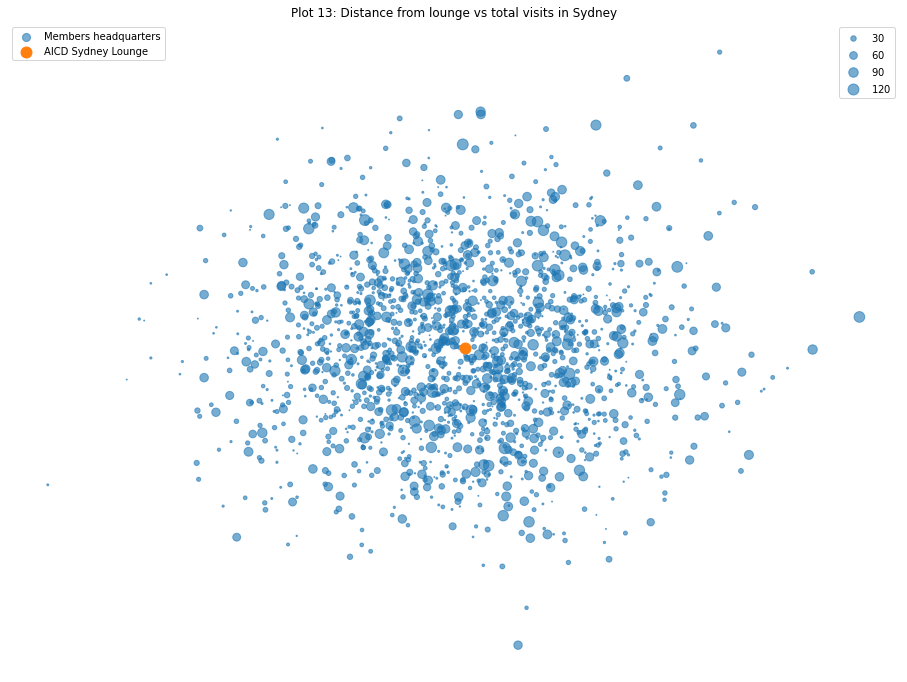

In [23]:
fig, ax = plt.subplots(figsize=(16,12))
sc = plt.scatter(hq_syd['longitude'], hq_syd['latitude'], s=hq_syd['total_visits'], alpha=0.6, label='Members headquarters')
plt.scatter(-33.86336382479448, 151.20641568508086, s=120, label='AICD Sydney Lounge')

legend2 = plt.legend(loc=2)
plt.gca().add_artist(legend2)
plt.legend(*sc.legend_elements("sizes", num=4, color='#1f77b4'))

plt.axis('off')
plt.title('Plot 13: Distance from lounge vs total visits in Sydney')
plt.show()

## Melbourne

In [24]:
x1 = hq_melb.groupby(pd.cut(hq_melb.melb_distance, bins))['avg_dwell_time_in_min'].count()
x2 = hq_melb.groupby(pd.cut(hq_melb.melb_distance, bins))['total_visits'].sum()
x3 = hq_melb.groupby(pd.cut(hq_melb.melb_distance, bins))['avg_dwell_time_in_min'].mean()
test1 = pd.concat([x1,x2,x3],axis=1)
test1.columns = ['Number of members','Total visits','Avg meeting time']
test1['Avg visits'] = test1['Total visits'] / test1['Number of members']
test1.index.names = ['Distance from Melbourne\'s AICD']
test1

,Number of members,Total visits,Avg meeting time,Avg visits
Distance from Melbourne's AICD,,,,
"(0, 5]",174,5551,130.522989,31.902299
"(5, 10]",369,11597,133.154472,31.428184
"(10, 15]",385,12289,143.187013,31.919481
"(15, 20]",235,8352,131.974468,35.540426
"(20, 25]",119,3258,138.487395,27.378151
"(25, 35]",69,2257,136.521739,32.710145
"(35, 50]",3,152,141.666667,50.666667


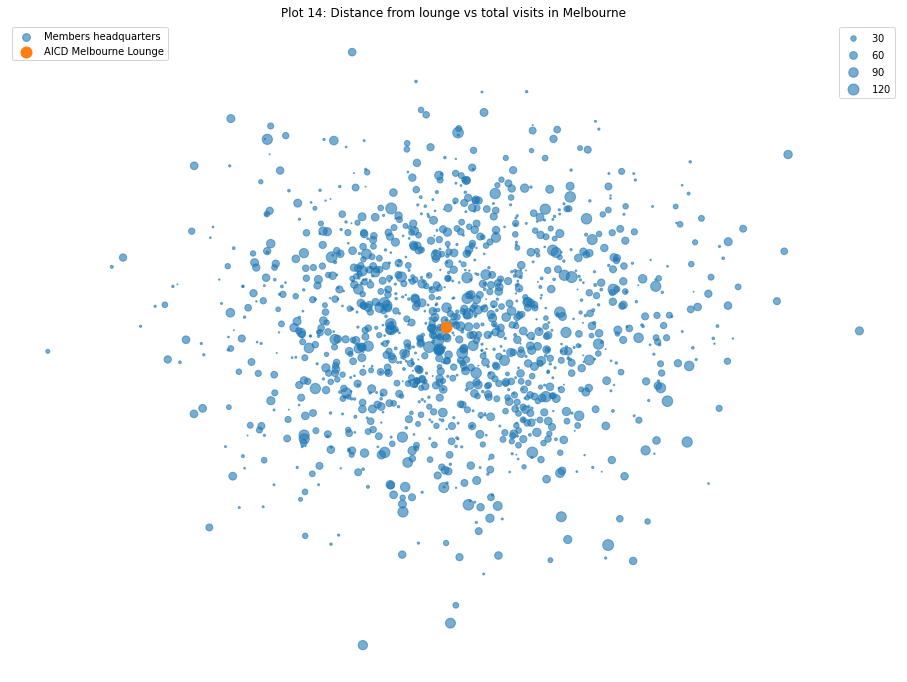

In [25]:
fig, ax = plt.subplots(figsize=(16,12))
plt.scatter(hq_melb['longitude'], hq_melb['latitude'], s=hq_melb['total_visits'], alpha=0.6,label='Members headquarters')
plt.scatter(-37.817007400214266, 144.96252718190436, s=120,label='AICD Melbourne Lounge')
plt.axis('off')
plt.title('Plot 14: Distance from lounge vs total visits in Melbourne')
legend2 = plt.legend(loc=2)
plt.gca().add_artist(legend2)
plt.legend(*sc.legend_elements("sizes", num=4, color='#1f77b4'))
plt.show()

## Perth

In [26]:
x1 = hq_perth.groupby(pd.cut(hq_perth.perth_distance, bins))['avg_dwell_time_in_min'].count()
x2 = hq_perth.groupby(pd.cut(hq_perth.perth_distance, bins))['total_visits'].sum()
x3 = hq_perth.groupby(pd.cut(hq_perth.perth_distance, bins))['avg_dwell_time_in_min'].mean()
test1 = pd.concat([x1,x2,x3],axis=1)
test1.columns = ['Number of members','Total visits','Avg meeting time']
test1['Avg visits'] = test1['Total visits'] / test1['Number of members']
test1.index.names = ['Distance from Perth\'s AICD']
test1

,Number of members,Total visits,Avg meeting time,Avg visits
Distance from Perth's AICD,,,,
"(0, 5]",121,4610,126.165289,38.099174
"(5, 10]",315,10827,128.730159,34.371429
"(10, 15]",248,10131,138.379032,40.850806
"(15, 20]",194,6599,132.597938,34.015464
"(20, 25]",103,3632,124.485437,35.262136
"(25, 35]",46,1251,141.108696,27.195652
"(35, 50]",7,346,140.428571,49.428571


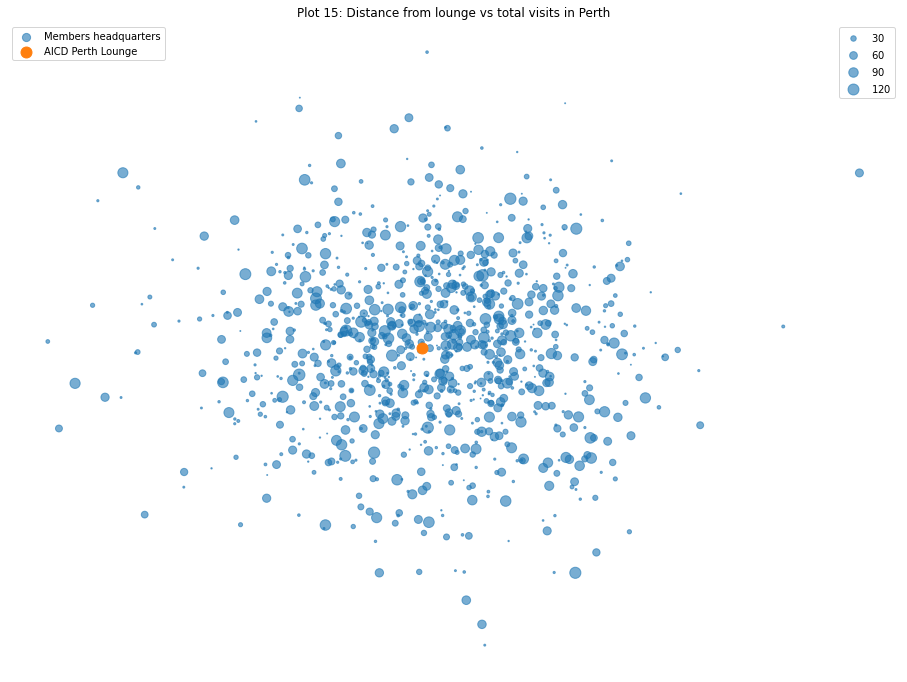

In [27]:
fig, ax = plt.subplots(figsize=(16,12))
plt.scatter(hq_perth['longitude'], hq_perth['latitude'], s=hq_perth['total_visits'], alpha=0.6,label='Members headquarters')
plt.scatter(-31.955110587081872, 115.85829166015982, s=120,label='AICD Perth Lounge')
plt.axis('off')
plt.title('Plot 15: Distance from lounge vs total visits in Perth')
legend2 = plt.legend(loc=2)
plt.gca().add_artist(legend2)
plt.legend(*sc.legend_elements("sizes", num=4, color='#1f77b4'))
plt.show()

We can notice some minor changes in average meeting time or the amount of average visits, but there's no clear correlation.
**Only the members with headquarters furthest from AICD lounge present different numbers, but their sample size is always too small to draw any conclusions.**

# Final conclusions:
* Sydney is the dominant lounge, attracting members from other cities, local members have the highest average number of visits to their local lounge and the lowest number of visits outside of their city
* Melbourne is the only city, where members are more likely to visit a lounge in a different city, than their own
    * When visiting Sydney or Perth they usually come from industries not popular in the Melbourne lounge
* AICD has a lot of CEOs as members (overall 36% of members are CEOs), yet they rarely visit any lounges
* Both in Sydney and Perth, Chairs are responsible for majority of visits both local and outside of their city,
    * In Melbourne's case, it's the Non-Executive Directors who generate the highest number of visits both locally and in other cities
* Distance of members company headquarters doesn't have an effect on their amount of visits or average visit time to the local AICD lounge

In [28]:
%%html
<script src="https://cdn.rawgit.com/parente/4c3e6936d0d7a46fd071/raw/65b816fb9bdd3c28b4ddf3af602bfd6015486383/code_toggle.js"></script>